## Análise Descritiva e Preditiva da Gestão de Esgotos em Goiás

### ADENILSON SILVA

Para controle do fluxo de atividades do projeto, a consultoria utilizou o trello. Painel: [aqui](https://trello.com/b/lFtNAxQD/projeto-analise-temporal-da-gestao-de-esgotos-em-goias-1992-2021-e-perspectivas-futuras-2022-2032).

# D - Criação de Modelos de _Machine Learning_

A seguir, é apresentado o código utilizado pela consultoria para a criação de Modelos de _Machine Learning_ do projeto.

Com base nos dados obtidos, foram aplicados 2 algoritmos de _Machine Learning_, sendo eles: 

1 - Método de Regressão Polinomial: Esse método de aprendizagem supervisionada foi utilizado para verificar se o comportamento das as _features_ “Volume de esgoto produzido - 1000 m³”, “Volume de esgotos coletado - 1000 m³” e “Volume de esgotos tratado - 1000 m³” poderia ser generalizado por meio de uma **função não linear**;

2 - Método de Regressão Linear: Esse método de aprendizagem supervisionada foi utilizado para verificar se o comportamento das as _features_ “Volume de esgoto produzido - 1000 m³”, “Volume de esgotos coletado - 1000 m³” e “Volume de esgotos tratado - 1000 m³” poderia generalizado por meio de uma **função linear**;

####  1 - Importando bibliotecas

In [14]:
import pandas as pd  # Biblioteca para trabalhar com dados em formato de tabela (DataFrame)
import matplotlib.pyplot as plt  # Biblioteca para criação de gráficos
import numpy as np  # Biblioteca para manipulação de arrays numéricos
import random  # Biblioteca para geração de números aleatórios
import os  # Usada para lidar com operações do sistema de arquivos
import joblib # Biblioteca para salvar e carregar modelos e objetos Python

from sklearn.linear_model import LinearRegression  # Importa o modelo de regressão linear
from sklearn.model_selection import cross_val_score  # Importa função para validação cruzada
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit #
from tabulate import tabulate  # Biblioteca para formatar tabelas
from scipy import stats # Importa o módulo scipy.stats para estatísticas

import warnings  # Biblioteca para controle de avisos durante a execução do código
warnings.filterwarnings('ignore')  # Suprime avisos

#### 2 -  Obtendo todos os dados tratados


In [2]:
# Gerando o Dataframe com a série histórica da coleta e tratamento de esgotos dos municipios de Goiás
df = pd.read_csv('dados_GO/B - dado_tratado/df_municipios_habitantes_saneamento_codigo.csv', 
                delimiter = ';',
                encoding = 'utf-8',
                index_col= False)

# Ordenando o DataFrame df por Município e Ano
df = df.sort_values(['Município', 'Ano'])

# Visualizando os primeiros 5 registros do Dataframe
df.head()

,Código do Município (IBGE),Município,Ano,População Total Urbana,Volume de esgoto produzido - 1000 m³,Volume de esgotos coletado - 1000 m³,Volume de esgotos tratado - 1000 m³
0,5200050.0,Abadia de Goiás,1992,0,0.00,0.0,0.0
246,5200050.0,Abadia de Goiás,1993,0,0.00,0.0,0.0
492,5200050.0,Abadia de Goiás,1994,0,0.00,0.0,0.0
738,5200050.0,Abadia de Goiás,1995,0,0.00,0.0,0.0
6396,5200050.0,Abadia de Goiás,1996,1560,74.02,0.0,0.0


In [3]:
# Criando um DataFrame 'df_go' que agrupa a população urbana por ano
df_go = pd.DataFrame(df.groupby('Ano')['Volume de esgoto produzido - 1000 m³', 
                                        'Volume de esgotos coletado - 1000 m³',
                                        'Volume de esgotos tratado - 1000 m³'].sum()).reset_index()


# Exibindo as primeiras linhas do DataFrame 'df_ano'
df_go.head()

,Ano,Volume de esgoto produzido - 1000 m³,Volume de esgotos coletado - 1000 m³,Volume de esgotos tratado - 1000 m³
0,1992,175585.65,0.0,0.0
1,1993,178712.42,0.0,0.0
2,1994,181682.00,0.0,0.0
3,1995,184578.25,0.0,0.0
4,1996,191674.24,9285.6,7365.7


#### 3 -  Criando as variáveis e métodos que serão usados nos modelos

In [7]:
# Filtrando o DataFrame para anos maiores que 1996
# Será usado nas previsões das features 'Volume de esgotos coletado - 1000 m³' e 'Volume de esgotos tratado - 1000 m³'
df_filtered = df_go[df_go['Ano'] > 1996]

# Definindo nomes das colunas relevantes
nome_coluna_produzido = 'Volume de esgoto produzido - 1000 m³'
nome_coluna_coletado = 'Volume de esgotos coletado - 1000 m³'
nome_coluna_tratado = 'Volume de esgotos tratado - 1000 m³'
nome_coluna_municipio = 'Município'
nome_coluna_ano = 'Ano'

# Separando as variáveis independentes e dependentes para análises futuras
X1 = df_go[nome_coluna_ano]
X2 = df_filtered[nome_coluna_ano] 

y1 = df_go[nome_coluna_produzido]
y2 = df_filtered[nome_coluna_coletado]
y3 = df_filtered[nome_coluna_tratado]

# Definindo nomes das colunas para clusters 
nome_coluna_cluster_produzido = 'Cluster_produzido'
nome_coluna_cluster_coletado = 'Cluster_coletado'
nome_coluna_cluster_tratado = 'Cluster_tratado'

# Estabelecendo uma faixa de anos futuros
anos_futuros = np.arange(2022, 2033).reshape(-1, 1)


In [11]:
def plotar_unico_grafico_multi_curvas(x_values, y_values, titulo, rotulo, eixos):
    """
    Plota um único gráfico com múltiplas curvas.

    Parâmetros:
    -----------
    x_values : list of lists
        Lista contendo listas de valores do eixo X para cada curva.
    y_values : list of lists
        Lista contendo listas de valores do eixo Y para cada curva.
    titulo : str
        Título do gráfico.
    rotulo : list of str
        Lista de rótulos para cada curva do gráfico.
    eixos : tuple or list of str
        Lista ou tupla contendo os rótulos dos eixos (xlabel, ylabel).

    Funcionalidade:
    ---------------
    - Cria um gráfico com múltiplas curvas utilizando os dados fornecidos.
    - Cada curva recebe uma cor aleatória.
    - Adiciona título, rótulos dos eixos, legenda e grade ao gráfico.
    
    Retorno:
    --------
    Nenhum (exibe o gráfico na tela).

    Exemplo de uso:
    ---------------
    >>> x = [[1, 2, 3], [1, 2, 3]]
    >>> y = [[2, 4, 6], [1, 3, 5]]
    >>> plotar_unico_grafico_multi_curvas(x, y, "Exemplo de Gráfico", ["Curva 1", "Curva 2"], ("Eixo X", "Eixo Y"))
    """
    # Criando uma figura para o gráfico com tamanho específico
    plt.figure(figsize=(12, 8)) 
    
    # Iterando sobre as curvas para plotar cada uma com uma cor aleatória e rótulo
    for i in range(len(x_values)):
        cor = definir_cor_aleatoria()
        plt.plot(x_values[i], y_values[i], color=cor, label=rotulo[i])
    
    # Adicionando um título ao gráfico
    plt.title(titulo) 
    
    # Adicionando rótulos aos eixos X e Y
    plt.xlabel(eixos[0]) 
    plt.ylabel(eixos[1])  
    
    # Adicionando uma legenda para as curvas
    plt.legend()
    
    # Ativando a grade no gráfico
    plt.grid(True)  
    
    # Exibindo o gráfico
    plt.show()
    
            
def validar_cruzadamente(cv, X, y):
    """
    Realiza validação cruzada em um modelo de regressão linear e calcula a média do erro quadrático médio.

    Parâmetros:
    -----------
    cv : int or cross-validation generator
        Número de divisões (folds) para a validação cruzada ou um gerador de validação cruzada.
    X : array-like, shape (n_samples, n_features)
        Conjunto de dados com as variáveis independentes (features).
    y : array-like, shape (n_samples,)
        Conjunto de dados com a variável dependente (target).

    Funcionalidade:
    ---------------
    - Cria um modelo de regressão linear.
    - Aplica validação cruzada ao modelo utilizando o número de divisões (cv) informado.
    - Calcula o erro quadrático médio (MSE) para cada divisão e retorna a média dos erros.

    Retorno:
    --------
    tuple:
        - mean_mse (float): Média dos valores do erro quadrático médio.
        - modelo (LinearRegression): Instância do modelo de regressão linear criado.

    Exemplo de uso:
    ---------------
    >>> from sklearn.model_selection import KFold
    >>> from sklearn.datasets import make_regression
    >>> X, y = make_regression(n_samples=100, n_features=2, noise=0.1)
    >>> cv = KFold(n_splits=5)
    >>> validar_cruzadamente(cv, X, y)
    (valor_do_erro_medio, modelo_de_regressao)
    """
    # Criando uma instância de modelo de regressão linear
    modelo = LinearRegression()
    
    # Realizando validação cruzada e obtendo pontuações de erro quadrático médio negativo
    scores = cross_val_score(modelo, X, y, cv=cv, scoring='neg_mean_squared_error')
    
    # Mantendo os valores negativos do erro quadrático médio (os valores são negativos por padrão)
    mse_scores = -scores
    
    # Calculando a média dos valores do erro quadrático médio
    mean_mse = mse_scores.mean()
    
    # Retornando a média do erro quadrático médio e o modelo treinado
    return mean_mse, modelo


def medir_desempenho_grau_regressao_polinomial(X, y, cv=5, graus=list(range(1, 11))):
    """
    Avalia o desempenho de modelos de regressão polinomial para diferentes graus utilizando validação cruzada.

    Parâmetros:
    -----------
    X : array-like, shape (n_samples, n_features)
        Conjunto de dados com as variáveis independentes (features).
    y : array-like, shape (n_samples,)
        Conjunto de dados com a variável dependente (target).
    cv : int or cross-validation generator, opcional (padrão=5)
        Número de divisões (folds) para a validação cruzada ou um gerador de validação cruzada.
    graus : list of int, opcional (padrão=list(range(1, 11)))
        Lista contendo os graus polinomiais a serem testados.

    Funcionalidade:
    ---------------
    - Itera sobre diferentes graus polinomiais e transforma as features para o respectivo grau.
    - Mede o desempenho do modelo para cada grau usando validação cruzada.
    - Treina o modelo e calcula métricas como o erro quadrático médio (RMSE) e o coeficiente de determinação (R²).
    - Armazena os resultados em uma lista formatada.

    Retorno:
    --------
    list of str:
        Lista contendo strings com as métricas de desempenho para cada grau polinomial.

    Exemplo de uso:
    ---------------
    >>> from sklearn.datasets import make_regression
    >>> X, y = make_regression(n_samples=100, n_features=1, noise=10)
    >>> desempenho = medir_desempenho_grau_regressao_polinomial(X, y)
    >>> for resultado in desempenho:
    >>>     print(resultado)
    """
    # Lista para armazenar as métricas de desempenho
    desempenho = []
    
    # Iterando sobre os diferentes graus de polinômios
    for grau in graus:
        # Criando recursos polinomiais com o grau especificado
        poly_features = PolynomialFeatures(degree=grau)
        X_poly = poly_features.fit_transform(X) 
        
        # Medindo o desempenho do modelo com validação cruzada
        mean_mse, modelo = validar_cruzadamente(cv, X_poly, y)
        
        # Treinando o modelo
        modelo.fit(X_poly, y)
        
        # Fazendo previsões
        y_pred = modelo.predict(X_poly)
        
        # Calculando o coeficiente de determinação (R²)
        r_squared = r2_score(y, y_pred)
        
        # Armazenando as métricas de desempenho em uma lista
        desempenho.append(f'Grau:{grau}, \
        Raiz do Erro Quadrático Médio (RMSE):{np.sqrt(mean_mse).round(2)},\
        R²:{r_squared.round(6)}')
    
    return desempenho


def aplicar_regressao_polinomial(X, y, graus):
    """
    Aplica regressão polinomial a um conjunto de dados e retorna as previsões, o modelo treinado e o objeto PolynomialFeatures.

    Parâmetros:
    -----------
    X : array-like, shape (n_samples,)
        Conjunto de dados com a variável independente (feature).
    y : array-like, shape (n_samples,)
        Conjunto de dados com a variável dependente (target).
    graus : int
        Grau do polinômio a ser ajustado.

    Funcionalidade:
    ---------------
    - Transforma a variável independente X em um conjunto de recursos polinomiais de acordo com o grau especificado.
    - Treina um modelo de regressão linear com os recursos polinomiais.
    - Faz previsões usando o modelo treinado.

    Retorno:
    --------
    tuple:
        - y_pred (array): Valores previstos pelo modelo.
        - modelo (LinearRegression): Modelo de regressão linear treinado com os recursos polinomiais.
        - feature_poli (PolynomialFeatures): Objeto PolynomialFeatures usado para transformar os dados.

    Exemplo de uso:
    ---------------
    >>> import numpy as np
    >>> import pandas as pd
    >>> X = pd.Series(np.array([1, 2, 3, 4, 5]))
    >>> y = np.array([2, 4, 9, 16, 25])
    >>> y_pred, modelo, feature_poli = aplicar_regressao_polinomial(X, y, graus=2)
    >>> print(y_pred)
    """
    # Criando instância do objeto PolynomialFeatures com o grau especificado
    feature_poli = PolynomialFeatures(degree=graus)
    
    # Transformando os recursos de entrada em recursos polinomiais
    X_poly = feature_poli.fit_transform(X.values.reshape(-1, 1))
    
    # Criando um modelo de regressão linear
    modelo = LinearRegression()
    
    # Treinando o modelo com os recursos polinomiais e os valores de saída
    modelo.fit(X_poly, y)
    
    # Fazendo previsões usando o modelo treinado
    y_pred = modelo.predict(X_poly)
    
    # Retornando as previsões, o modelo treinado e o objeto PolynomialFeatures
    return y_pred, modelo, feature_poli


def aplicar_regressao_linear(X, y, cv=5):
    """
    Aplica regressão linear a um conjunto de dados e retorna as previsões, o modelo treinado, o erro médio quadrático médio (MSE) e o coeficiente de determinação (R²).

    Parâmetros:
    -----------
    X : array-like, shape (n_samples,)
        Conjunto de dados com a variável independente (feature).
    y : array-like, shape (n_samples,)
        Conjunto de dados com a variável dependente (target).
    cv : int, opcional (padrão=5)
        Número de folds para a validação cruzada.

    Funcionalidade:
    ---------------
    - Realiza validação cruzada para calcular o erro médio quadrático médio (MSE).
    - Treina um modelo de regressão linear com os dados fornecidos.
    - Faz previsões usando o modelo treinado.
    - Calcula o coeficiente de determinação (R²) para avaliar a qualidade do ajuste.

    Retorno:
    --------
    tuple:
        - y_pred (array): Valores previstos pelo modelo.
        - modelo (LinearRegression): Modelo de regressão linear treinado.
        - mean_mse (float): Média do erro médio quadrático médio obtido na validação cruzada.
        - r_squared (float): Coeficiente de determinação R² do modelo.

    Exemplo de uso:
    ---------------
    >>> import numpy as np
    >>> import pandas as pd
    >>> X = pd.Series(np.array([1, 2, 3, 4, 5]))
    >>> y = np.array([2, 4, 6, 8, 10])
    >>> y_pred, modelo, mean_mse, r_squared = aplicar_regressao_linear(X, y)
    >>> print(f"MSE: {mean_mse}, R²: {r_squared}")
    """
    # Calculando o erro médio quadrático médio e obtendo o modelo através de validação cruzada
    mean_mse, modelo = validar_cruzadamente(cv, X.values.reshape(-1, 1), y)
    
    # Treinando o modelo linear com os dados de entrada e saída
    modelo.fit(X.values.reshape(-1, 1), y)
    
    # Realizando previsões com o modelo treinado
    y_pred = modelo.predict(X.values.reshape(-1, 1))
    
    # Calculando o coeficiente de determinação R² para avaliar o modelo
    r_squared = r2_score(y, y_pred)
  
    # Retornando as previsões, o modelo, o erro médio quadrático médio e o R²
    return y_pred, modelo, mean_mse, r_squared




def calcular_p_value_alpha_05(x, y_real, y_pred):
    """
    Calcula o valor p para um teste t de amostras pareadas entre valores reais e previstos, utilizando um nível de significância de 0.05.

    Parâmetros:
    -----------
    x : array-like
        Valores da variável independente (exemplo: anos ou qualquer outra variável preditiva).
    y_real : array-like
        Valores reais da variável dependente (target).
    y_pred : array-like
        Valores previstos pelo modelo.

    Funcionalidade:
    ---------------
    - Cria um DataFrame com os valores reais e previstos.
    - Calcula a diferença entre os valores previstos e os reais.
    - Executa um teste t de amostras pareadas para verificar se há diferença estatisticamente significativa entre os valores reais e os previstos.
    - Compara o p-value obtido com um nível de significância de 0.05 para determinar se a diferença é significativa.

    Retorno:
    --------
    None:
        - Exibe uma mensagem informando se a diferença entre os valores reais e previstos é estatisticamente significativa.

    Exemplo de uso:
    ---------------
    >>> import numpy as np
    >>> x = np.array([2000, 2001, 2002, 2003, 2004])
    >>> y_real = np.array([100, 150, 200, 250, 300])
    >>> y_pred = np.array([110, 145, 190, 260, 310])
    >>> calcular_p_value_alpha_05(x, y_real, y_pred)
    """
    df_teste_p_valor = pd.DataFrame({'Ano': x, 'Valor Real': y_real, 'Valor Previsto': y_pred})
    
    # Calculando a diferença entre os valores previstos e reais
    df_teste_p_valor['Diferença'] = df_teste_p_valor['Valor Previsto'] - df_teste_p_valor['Valor Real']
    
    # Realizando o teste t de amostras pareadas
    t_statistic, p_valor = stats.ttest_rel(df_teste_p_valor['Valor Previsto'], 
                                           df_teste_p_valor['Valor Real'])
    
    # Definindo o nível de significância (alpha)
    alpha = 0.05  
    
    # Verificando se a diferença é estatisticamente significativa
    if p_valor < alpha:
        print(f"Diferença estatisticamente significativa (p_value: {p_valor.round(8)})")
    else:
        print(f"Não há diferença estatisticamente significativa (p_value: {p_valor.round(8)})")
        
        
def definir_cor_aleatoria():
    """
    Gera uma cor aleatória no formato hexadecimal "#RRGGBB".

    A cor é gerada a partir de valores aleatórios para os três canais de cor: vermelho (red), verde (green) e azul (blue), 
    variando entre 0 e 200 para cada canal. Em seguida, esses valores são combinados para criar uma representação 
    hexadecimal da cor.

    Retorno:
    --------
    str:
        A cor gerada no formato hexadecimal "#RRGGBB", onde RR, GG e BB são os valores hexadecimais dos canais 
        de cor vermelho, verde e azul, respectivamente.

    Exemplo de uso:
    ---------------
    >>> cor = definir_cor_aleatoria()
    >>> print(cor)
    '#1a2b3c'
    """
    # Gerando valores aleatórios para os canais de cor (vermelho, verde e azul).
    red = random.randint(0, 200)
    green = random.randint(0, 200)
    blue = random.randint(0, 200)
    
    # Criando uma representação hexadecimal da cor combinando os canais de cor.
    cor = "#{:02x}{:02x}{:02x}".format(red, green, blue)
    
    # Retornando a cor gerada no formato "#RRGGBB".
    return cor


#### 3 -  Aplicando Regressão Polinomial aos dados agrupados para o estado de Goiás

**Observação:**

Em fase anterior à aplicação do Método de Regressão Polinomial, foi aplicado aos dados a função que mediu o desempenho do modelo a fim de estabelecer o valor mais adequado para o grau da função. Nesse processo foram usados os indicadores estatísticos “Raiz do Erro Quadrático Médio” e “Coeficiente de Determinação - R²”. Ressalta-se que, aos modelos, foi aplicado validação cruzada utilizando 5 dobras (20%).

In [12]:
# Estabelecendo o número de dobras que será empregado na validação cruzada
cv = 5

# Aplicando o modelo de regressão poliminal em cada feature
desempenho_produzido = medir_desempenho_grau_regressao_polinomial(X1.values.reshape(-1, 1), y1, cv)
desempenho_coletado = medir_desempenho_grau_regressao_polinomial(X2.values.reshape(-1, 1), y2, cv)
desempenho_tratado = medir_desempenho_grau_regressao_polinomial(X2.values.reshape(-1, 1), y3, cv)

print('** Regressão Polinomial: Volume de esgoto produzido - 1000 m³ ** ')
tabela = [item.split(', ') for item in desempenho_produzido]
print(tabulate(tabela, tablefmt='fancy_grid'))
print('\n')

print('** Regressão Polinomial: Volume de esgotos coletado - 1000 m³ **')
tabela = [item.split(', ') for item in desempenho_coletado]
print(tabulate(tabela, tablefmt='fancy_grid'))
print('\n')

print('** Regressão Polinomial: Volume de esgotos tratado - 1000 m³ **')
tabela = [item.split(', ') for item in desempenho_tratado]
print(tabulate(tabela, tablefmt='fancy_grid'))

** Regressão Polinomial: Volume de esgoto produzido - 1000 m³ ** 
╒═════════╤══════════════════════════════════════════════╤═════════════╕
│ Grau:1  │ Raiz do Erro Quadrático Médio (RMSE):3306.11 │ R²:0.996375 │
├─────────┼──────────────────────────────────────────────┼─────────────┤
│ Grau:2  │ Raiz do Erro Quadrático Médio (RMSE):3068.89 │ R²:0.997102 │
├─────────┼──────────────────────────────────────────────┼─────────────┤
│ Grau:3  │ Raiz do Erro Quadrático Médio (RMSE):3648.3  │ R²:0.997205 │
├─────────┼──────────────────────────────────────────────┼─────────────┤
│ Grau:4  │ Raiz do Erro Quadrático Médio (RMSE):3627.8  │ R²:0.997206 │
├─────────┼──────────────────────────────────────────────┼─────────────┤
│ Grau:5  │ Raiz do Erro Quadrático Médio (RMSE):3607.22 │ R²:0.997207 │
├─────────┼──────────────────────────────────────────────┼─────────────┤
│ Grau:6  │ Raiz do Erro Quadrático Médio (RMSE):3586.77 │ R²:0.997208 │
├─────────┼──────────────────────────────────────────────┼

**Observação:**

Definido o valor 10, 3 e 3 de graus para as _features_ “Volume de esgoto produzido - 1000 m³”, “Volume de esgotos coletado - 1000 m³” e “Volume de esgotos tratado - 1000 m³”, respectivamente.

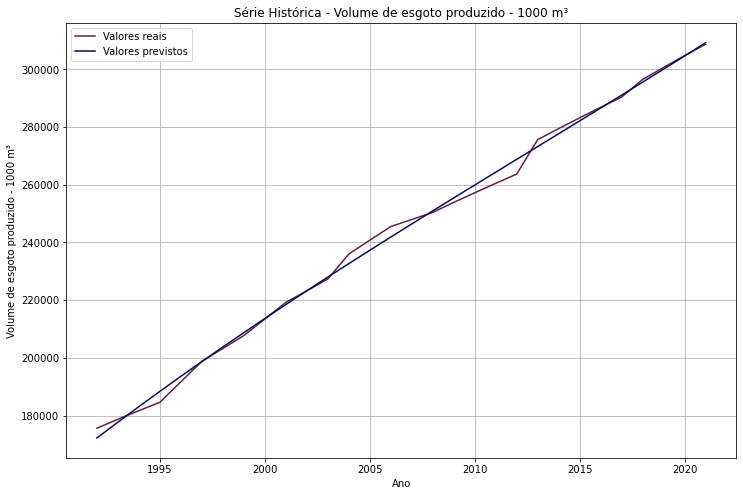

Não há diferença estatisticamente significativa (p_value: 1.0)


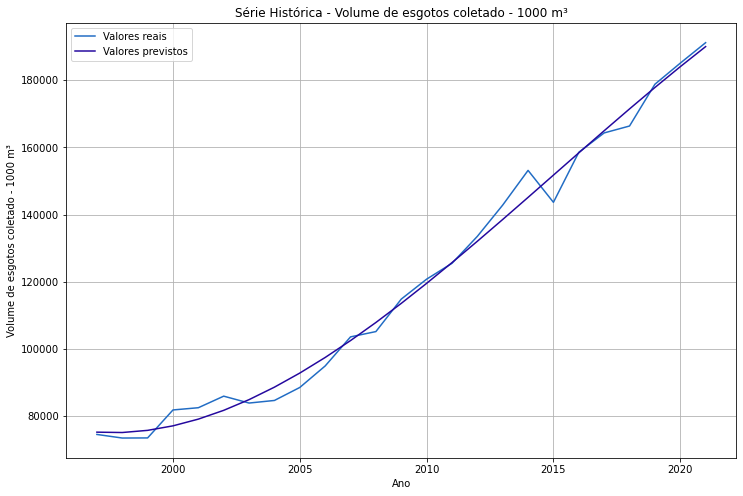

Não há diferença estatisticamente significativa (p_value: 0.99999999)


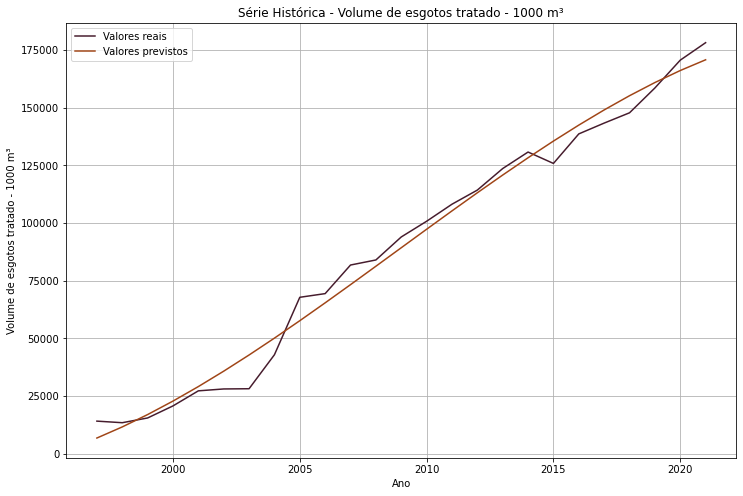

Não há diferença estatisticamente significativa (p_value: 0.99999999)


In [15]:
# Atribuindo o valor do grau de cada modelo
# Este valor foi obtido por intermédio do por intermédio da função de avaliação de empenho
grau_produzido = 10
grau_coletado = 3
grau_tratado = 3

# Aplicando o modelo de regrassão polinomial aos dados
# Após a aplicação do modelo, serão retornados os valores preditos de teste
pred_y_poli_produzido, modelo_poli_produzido, feature_poli_produzido = aplicar_regressao_polinomial(X1, y1, 10)
pred_y_poli_coletado, modelo_poli_coletado, feature_poli_coletado = aplicar_regressao_polinomial(X2, y2, 3)
pred_y_poli_tratado, modelo_poli_tratado, feature_poli_tratado = aplicar_regressao_polinomial(X2, y3, 3)

# Criando duas cópias do DataFrame df para que sejam utilizados unicamente neste modelo
df_reg_poli_teste_prod = df_go.copy().drop(columns=["Volume de esgotos coletado - 1000 m³","Volume de esgotos tratado - 1000 m³"])
df_reg_poli_teste_prod['Volume de esgoto produzido - 1000 m³ (previsto em teste) '] = pred_y_poli_produzido
df_reg_poli_teste_col_trat = df_filtered.copy().drop(columns=["Volume de esgoto produzido - 1000 m³"])
df_reg_poli_teste_col_trat['Volume de esgoto coletado - 1000 m³ (previsto em teste)'] = pred_y_poli_coletado
df_reg_poli_teste_col_trat['Volume de esgoto tratado - 1000 m³ (previsto em teste)'] = pred_y_poli_tratado

# Plotando o gráfico com os dados reais e os dados preditos no teste e definindo o p_value
titulo_produzido = 'Série Histórica - '+ nome_coluna_produzido
titulo_coletado = 'Série Histórica - '+ nome_coluna_coletado
titulo_tratado = 'Série Histórica - '+ nome_coluna_tratado
label_real = 'Valores reais'
label_prev = 'Valores previstos'

plotar_unico_grafico_multi_curvas([X1, X1], [y1, pred_y_poli_produzido], 
                                  titulo_produzido, [label_real, label_prev], [nome_coluna_ano,nome_coluna_produzido])
calcular_p_value_alpha_05(X1.values, y1.values, pred_y_poli_produzido)
plotar_unico_grafico_multi_curvas([X2, X2], [y2, pred_y_poli_coletado], 
                                  titulo_coletado, [label_real, label_prev], [nome_coluna_ano,nome_coluna_coletado])
calcular_p_value_alpha_05(X2.values, y2.values, pred_y_poli_coletado)
plotar_unico_grafico_multi_curvas([X2, X2], [y3, pred_y_poli_tratado], 
                                  titulo_tratado, [label_real, label_prev], [nome_coluna_ano,nome_coluna_tratado])
calcular_p_value_alpha_05(X2.values, y3.values, pred_y_poli_tratado)

In [16]:
# Verificando se a pasta "dados_GO/D - dado_predito/regressao_polinomial/teste" já existe
if not os.path.exists('dados_GO/D - dado_predito/regressao_polinomial/teste'):
    # Se não existir, cria a pasta
    os.makedirs('dados_GO/D - dado_predito/regressao_polinomial/teste')

# Verificando se a pasta "dados_GO/D - dado_predito/regressao_polinomial/modelo" já existe
if not os.path.exists('dados_GO/D - dado_predito/regressao_polinomial/modelos'):
    # Se não existir, cria a pasta
    os.makedirs('dados_GO/D - dado_predito/regressao_polinomial/modelos')

#Salvando o arquivo CSV e o Modelo de Regressão no diretório "dados_GO/D - dado_predito/regressao_polinomial/teste/" 
#como dados relativos à clusterização 
df_reg_poli_teste_prod.to_csv('dados_GO/D - dado_predito/regressao_polinomial/teste/df_reg_poli_teste_prod.csv', 
                              index=False, sep=';')
df_reg_poli_teste_col_trat.to_csv('dados_GO/D - dado_predito/regressao_polinomial/teste/df_reg_poli_teste_col_trat.csv', 
                                  index=False, sep=';')

joblib.dump(modelo_poli_produzido, 'dados_GO/D - dado_predito/regressao_polinomial/modelos/modelo_reg_poli_produzido.pkl')
joblib.dump(modelo_poli_coletado, 'dados_GO/D - dado_predito/regressao_polinomial/modelos/modelo_reg_poli_coletado.pkl')
joblib.dump(modelo_poli_tratado, 'dados_GO/D - dado_predito/regressao_polinomial/modelos/modelo_reg_poli_tratado.pkl')

['dados_GO/D - dado_predito/regressao_polinomial/modelos/modelo_reg_poli_tratado.pkl']

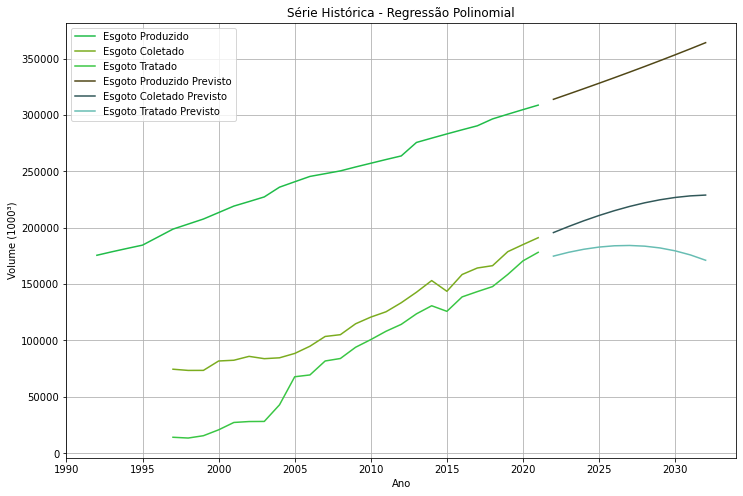

In [17]:
# Aplicando o modelo de regressão polinomial aos dados para predição dos anos 2022 a 2032
# Após a aplicação do modelo, serão retornados os valores preditos
y_pred_poli_futuro_produzido = modelo_poli_produzido.predict(feature_poli_produzido.transform(anos_futuros))
y_pred_poli_futuro_coletado = modelo_poli_coletado.predict(feature_poli_tratado.transform(anos_futuros))
y_pred_poli_futuro_tratado = modelo_poli_tratado.predict(feature_poli_coletado.transform(anos_futuros))

# Plotando o gráfico com os dados reais e os dados preditos
X_multi = [X1, X2, X2, anos_futuros, anos_futuros, anos_futuros]
y_multi = [y1, y2, y3, y_pred_poli_futuro_produzido, y_pred_poli_futuro_coletado, y_pred_poli_futuro_tratado]
titulo = 'Série Histórica - Regressão Polinomial'
label_real = ['Esgoto Produzido','Esgoto Coletado','Esgoto Tratado']
label_prev = ['Esgoto Produzido Previsto','Esgoto Coletado Previsto','Esgoto Tratado Previsto']
label_prev = label_real + label_prev
label_x = ['Ano']
label_y = ['Volume (1000³)']
label_eixos = label_x + label_y

plotar_unico_grafico_multi_curvas(X_multi, y_multi, titulo, label_prev, label_eixos)

#### 4 - Aplicando Regressão Linear aos dados agrupados para o estado de Goiás

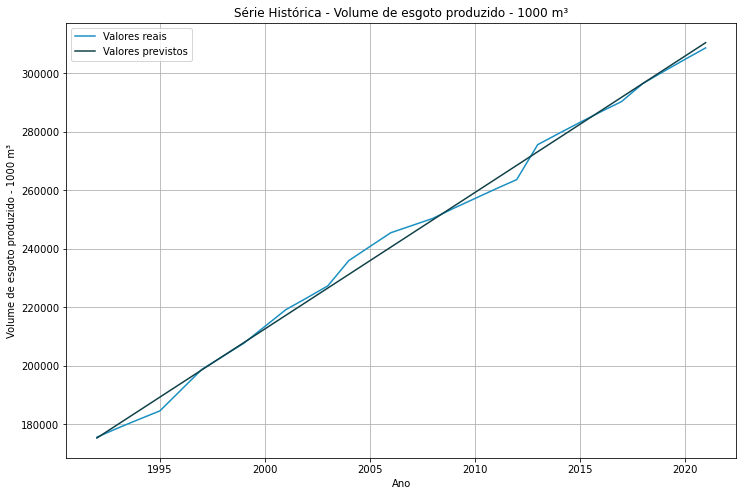

Não há diferença estatisticamente significativa (p_value: 1.0)
Raiz do Erro Quadrático Médio Médio (Cross-Validation): 3306.1087130919227
Coeficiente de Determinação (R²): 0.9964 



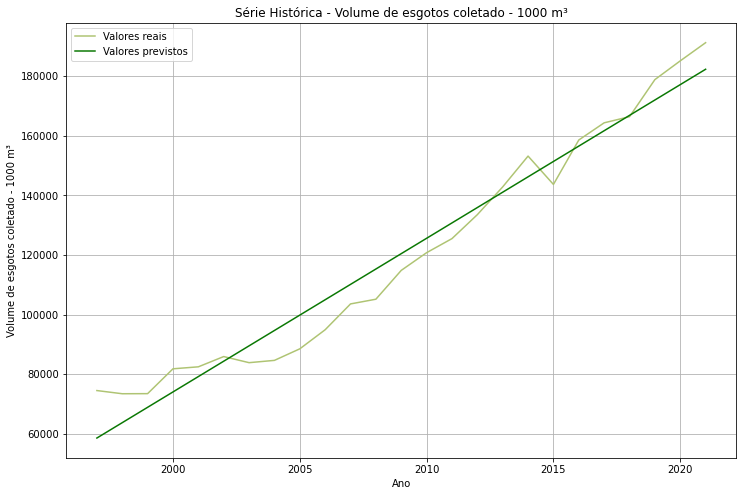

Não há diferença estatisticamente significativa (p_value: 1.0)
Raiz do Erro Quadrático Médio Médio (Cross-Validation): 13026.674882040394
Coeficiente de Determinação (R²): 0.9624 



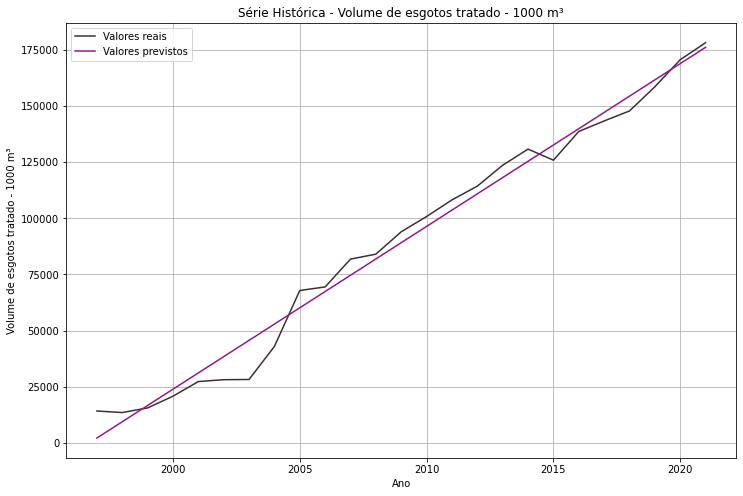

Não há diferença estatisticamente significativa (p_value: 1.0)
Raiz do Erro Quadrático Médio Médio (Cross-Validation): 7795.133173668253
Coeficiente de Determinação (R²): 0.9846 



In [18]:
# Estabelecendo o número de dobras que será empregado na validação cruzada
cv = 5

# Aplicando o modelo de regressão lienar em cada feature
pred_y_linear_produzido, modelo_linear_produzido, eqm_linear_produzido, r2_lienar_produzido =\
aplicar_regressao_linear(X1, y1, cv)
pred_y_linear_coletado, modelo_linear_coletado, eqm_linear_coletado, r2_lienar_coletado =\
aplicar_regressao_linear(X2, y2, cv)
pred_y_linear_tratado, modelo_linear_tratado, eqm_linear_tratado, r2_lienar_tratado =\
aplicar_regressao_linear(X2, y3, cv)


# Plotando o gráfico com os dados reais e os dados preditos no teste e definindo o p_value
titulo_produzido = 'Série Histórica - '+ nome_coluna_produzido
titulo_coletado = 'Série Histórica - '+ nome_coluna_coletado
titulo_tratado = 'Série Histórica - '+ nome_coluna_tratado
label_real = 'Valores reais'
label_prev = 'Valores previstos'

plotar_unico_grafico_multi_curvas([X1, X1], [y1, pred_y_linear_produzido], 
                                  titulo_produzido, [label_real, label_prev], [nome_coluna_ano,nome_coluna_produzido])
calcular_p_value_alpha_05(X1.values, y1.values, pred_y_linear_produzido)
print(f'Raiz do Erro Quadrático Médio Médio (Cross-Validation): {np.sqrt(eqm_linear_produzido)}')
print(f'Coeficiente de Determinação (R²): {r2_lienar_produzido.round(4)} \n')
plotar_unico_grafico_multi_curvas([X2, X2], [y2, pred_y_linear_coletado], 
                                  titulo_coletado, [label_real, label_prev], [nome_coluna_ano,nome_coluna_coletado])
calcular_p_value_alpha_05(X2.values, y2.values, pred_y_linear_coletado)
print(f'Raiz do Erro Quadrático Médio Médio (Cross-Validation): {np.sqrt(eqm_linear_coletado)}')
print(f'Coeficiente de Determinação (R²): {r2_lienar_coletado.round(4)} \n')
plotar_unico_grafico_multi_curvas([X2, X2], [y3, pred_y_linear_tratado], 
                                  titulo_tratado, [label_real, label_prev], [nome_coluna_ano,nome_coluna_tratado])
calcular_p_value_alpha_05(X2.values, y3.values, pred_y_linear_tratado)
print(f'Raiz do Erro Quadrático Médio Médio (Cross-Validation): {np.sqrt(eqm_linear_tratado)}')
print(f'Coeficiente de Determinação (R²): {r2_lienar_tratado.round(4)} \n')

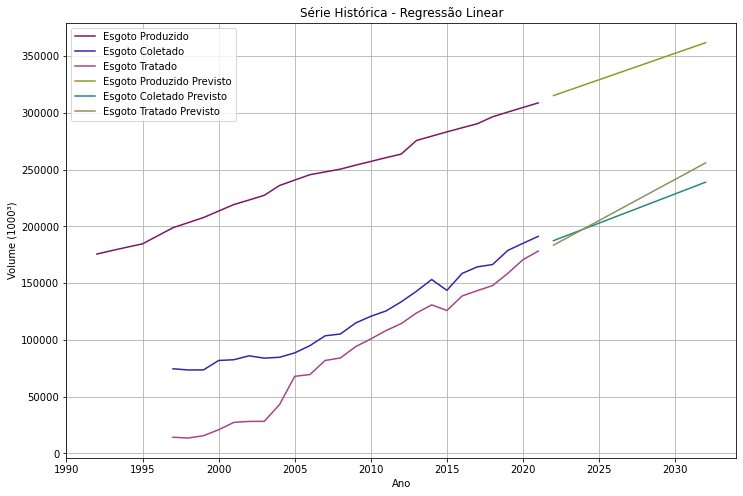

In [19]:
# Aplicando o modelo de regressão linear aos dados para predição dos anos 2022 a 2032
# Após a aplicação do modelo, serão retornados os valores preditos
y_pred_futuro_lienar_produzido = modelo_linear_produzido.predict(anos_futuros)
y_pred_futuro_linear_coletado = modelo_linear_coletado.predict(anos_futuros)
y_pred_futuro_linear_tratado = modelo_linear_tratado.predict(anos_futuros)


# Plotando o gráfico com os dados reais e os dados preditos
X_multi = [X1, X2, X2, anos_futuros, anos_futuros, anos_futuros]
y_multi = [y1, y2, y3, y_pred_futuro_lienar_produzido, y_pred_futuro_linear_coletado, y_pred_futuro_linear_tratado]
titulo = 'Série Histórica - Regressão Linear'
label_real = ['Esgoto Produzido','Esgoto Coletado','Esgoto Tratado']
label_prev = ['Esgoto Produzido Previsto','Esgoto Coletado Previsto','Esgoto Tratado Previsto']
label_prev = label_real + label_prev
label_x = ['Ano']
label_y = ['Volume (1000³)']
label_eixos = label_x + label_y

plotar_unico_grafico_multi_curvas(X_multi, y_multi, titulo, label_prev, label_eixos)

In [20]:
dic_verificacao_coletado_tratado = {'Ano': anos_futuros.flatten(), 
        'Volume de Esgoto Coletado': y_pred_futuro_linear_coletado, 
        'Volume de Esgoto Tratado': y_pred_futuro_linear_tratado,
        'Volume de Esgoto Produzido': y_pred_futuro_lienar_produzido}

df_verificacao_coletado_tratado = pd.DataFrame(dic_verificacao_coletado_tratado)

print('*** Ano em que todo o esgoto coletado estará sendo tratado: ***')
df_verificacao_coletado_tratado[df_verificacao_coletado_tratado['Volume de Esgoto Tratado'] 
                                >= df_verificacao_coletado_tratado['Volume de Esgoto Coletado']].head(1)

*** Ano em que todo o esgoto coletado estará sendo tratado: ***


,Ano,Volume de Esgoto Coletado,Volume de Esgoto Tratado,Volume de Esgoto Produzido
2,2024,197698.964885,197889.496592,324516.108065


In [21]:
print('*** Eficência do Volume de Esgoto tratado em 2032: ***')
a = df_verificacao_coletado_tratado['Volume de Esgoto Tratado'][df_verificacao_coletado_tratado['Ano'] == 2032].values
b = df_verificacao_coletado_tratado['Volume de Esgoto Produzido'][df_verificacao_coletado_tratado['Ano'] == 2032].values

print(str(float(((a/b)*100).round(2)))+'%')

*** Eficência do Volume de Esgoto tratado em 2032: ***
70.72%


## 5 -  Interpretação dos Resultados

- Observou-se que o Método de Regressão Polinomial apresentou comportamento satisfatório para as features "Volume de esgoto produzido - 1000 m³", "Volume de esgotos coletado - 1000 m³" e "Volume de esgotos tratados - 1000 m³";


- Ao analisar o gráfico gerado com os dados previstos pelo Método de Regressão Polinomial no período de 2022 a 2032, notou-se que as curvas relacionadas às _features_ "Volume de esgotos coletados - 1000 m³" e "Volume de esgotos tratados - 1000 m³" apresentaram uma tendência de queda, enquanto a curva referente à features "Volume de esgoto produzido - 1000 m³" demonstrou uma tendência de crescimento. Essa observação, na prática, sugere uma possível deterioração na qualidade dos serviços públicos de saneamento, indicando que o estado pode não estar alocando os recursos necessários para a manutenção e expansão desses serviços;


- Observou-se que o Método de Regressão Linear também apresentou comportamento satisfatório para as features "Volume de esgoto produzido - 1000 m³", "Volume de esgotos coletado - 1000 m³" e "Volume de esgotos tratados - 1000 m³";


- Ao analisar o gráfico gerado com os dados previstos pelo Método de Regressão Linear para o período de 2022 a 2032, observa-se que todas as _features_ possuem uma tendência de crescimento. Destaca-se que em 2024, a curva da feature "Volume de esgotos tratados - 1000 m³" cruzará a curva da feature "Volume de esgotos coletado - 1000 m³". Além disso, nota-se que a distância entre a feature "Volume de esgotos tratados - 1000 m³" e a feature "Volume de esgoto produzido - 1000 m³" está diminuindo ao longo do tempo. Essas constatações sugerem que a partir de 2024, a totalidade do esgoto coletado será adequadamente tratada. Além disso, a redução da distância entre as curvas indica uma possível melhoria na qualidade dos serviços públicos de saneamento, indicando que o estado pode estar alocando os recursos necessários para a expansão desses serviços.


- No contexto da comparação entre o Método de Regressão Linear e o Método de Regressão Polinomial, foram calculados diversos indicadores, incluindo a Raiz do Erro Quadrático Médio (RMSE), o Coeficiente de Determinação (R²) e o valor p de cada modelo. Seguem os resultados:

| Volume de esgoto produzido - 1000 m³ | Regressão Polinomial | Regressão Linear |
| :--- | :--- | :--- |
| RMSE | 3506,32 | 3306,11 |
| R² | 0,9970 | 0,9964 |
| p value | 1,0 | 1,0 |

| Volume de esgotos coletado - 1000 m³ | Regressão Polinomial | Regressão Linear |
| :--- | :--- | :--- |
| RMSE | 4231,92 | 13026,67 |
| R² | 0,9918 | 0,9624 |
| p value | 0,9999 | 1,0 |

| Volume de esgotos tratado - 1000 m³ | Regressão Polinomial | Regressão Linear |
| :--- | :--- | :--- |
| RMSE | 32714,42 | 7795,13 |
| R² | 0,986675 | 0,9646 |
| p value | 0,9999 | 1,0 |


**Ao analisar os valores, observa-se que o Método de Regressão Polinomial apresenta uma ligeira vantagem em relação ao Método de Regressão Linear. Portanto, será necessário incluir novos dados futuros para determinar qual modelo melhor representará a realidade de forma mais precisa**.

### Dados sobre versão

- Python: 3.11.4
- pandas==1.3.4
- matplotlib==3.4.3
- statsmodels==0.12.2
- numpy==1.23.5
- tabulate==0.9.0